# COVID-19 situation in the Netherlands and Globally

We want to understand how the current COVID-19 situation is doing, in the Netherlands and globally. To do so, we will use several datasets and look at the relative percentages. I have created this dashboard in the first week of September 2020, so the dashboard is up to date on the situation from January until August.

In [13]:
import os
import pandas as pd
import numpy as np
import sklearn
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.getcwd()
os.chdir('D:\Documents\Ferb')

The first dataset is an overview of all positive cases in the Netherlands. This dataset contains info about when the person was tested positive, the age group their in, their sex, the province where the person was tested and more.

In [116]:
#Load dataset about covid-19 and examine dataset
covid_df = pd.read_csv('COVID-19_casus_landelijk.csv', sep=';')
print(len(covid_df))
print(covid_df.head())

71863
             Date_file Date_statistics Date_statistics_type Agegroup     Sex  \
0  2020-09-02 10:00:00      2020-01-01                  DOO    40-49  Female   
1  2020-09-02 10:00:00      2020-01-20                  DOO    50-59  Female   
2  2020-09-02 10:00:00      2020-01-29                  DOO    80-89    Male   
3  2020-09-02 10:00:00      2020-01-31                  DOO    80-89    Male   
4  2020-09-02 10:00:00      2020-01-31                  DOO      90+  Female   

        Province Hospital_admission Deceased  Week_of_death  \
0  Noord-Holland                 No       No            NaN   
1     Gelderland                 No       No            NaN   
2     Overijssel                 No       No            NaN   
3  Noord-Brabant                Yes      Yes       202015.0   
4  Noord-Holland                 No       No            NaN   

  Municipal_health_service  
0            GGD Amsterdam  
1      GGD Gelderland-Zuid  
2         GGD Regio Twente  
3   GGD Brabant Zu

In [824]:
set(covid_df.Agegroup)

{'0-9',
 '10-19',
 '20-29',
 '30-39',
 '40-49',
 '50-59',
 '60-69',
 '70-79',
 '80-89',
 '90+',
 '<50',
 'Unknown'}

In [828]:
len(covid_df[(covid_df['Agegroup'] == '<50') | (covid_df['Agegroup'] == 'Unknown')])/len(covid_df)

0.0007235990704535018

## Age

I want to use the category 'Age' to see whether there are a lot of differences in getting infected between age groups. I use a seaborn categorical plot to display the amount of positive COVID-19 cases for each age group. Instead of defining a column to use for the y axis, I can specify kind="count" so the rows that belong in a specific age group are counted. I order by the age groups in ascending order. I have removed two age groups, '<50' and 'Unknown', as the cases in those age categories made up 0.0007% of the dataset. 

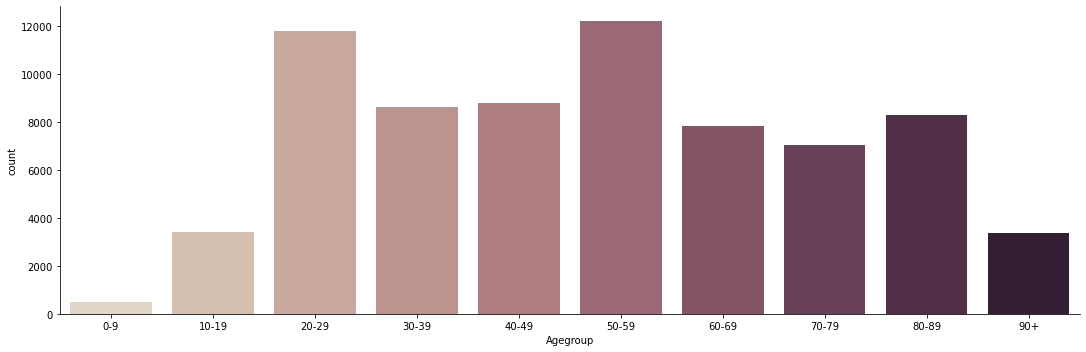

In [71]:
order = sorted(covid_df['Agegroup'].value_counts().index[:-2])
sns.catplot(x="Agegroup", kind="count", palette="ch:.25", data=covid_df, height=5, aspect=3, order=order)

We have plotted the amount of observations for each age group. This shows two categories that are barely used, '<50' and 'Unknown'. We will remove entries in this category. This graph also shows that there are more people that are tested positive for COVID-19 in the ages of 50-59 and 20-29. Intuitively this makes sense, as people between the age of 20 and 29 are probably more out and social with friends and part of student associations, which could be Corona hotspots. to assess whether this makes sense we will use data about the population in the Netherlands. We use data from StatLine, the database of CBS (Centraal Bureau voor Statistiek). https://opendata.cbs.nl/statline/#/CBS/nl/dataset/03759ned/table?ts=1599208414695&fromstatweb=true . This data contains information about the population on January 1st 2020. This means that the data is not updated and the calculated values should be seen as estimates. 

In [36]:
age_df = pd.read_csv('Bevolking_op_1_januari_en_gemiddelde__leeftijd.csv', sep=';')

In [37]:
age_df

,Geslacht,Leeftijd,Burgerlijke staat,Regio's,Perioden,Bevolking op 1 januari (aantal),Gemiddelde bevolking (aantal)
0,Totaal mannen en vrouwen,0 jaar,Totaal burgerlijke staat,Nederland,2020,169497,NaN
1,Totaal mannen en vrouwen,1 jaar,Totaal burgerlijke staat,Nederland,2020,169918,NaN
2,Totaal mannen en vrouwen,2 jaar,Totaal burgerlijke staat,Nederland,2020,171951,NaN
3,Totaal mannen en vrouwen,3 jaar,Totaal burgerlijke staat,Nederland,2020,175319,NaN
4,Totaal mannen en vrouwen,4 jaar,Totaal burgerlijke staat,Nederland,2020,174787,NaN
...,...,...,...,...,...,...,...
95,Totaal mannen en vrouwen,95 jaar,Totaal burgerlijke staat,Nederland,2020,8855,NaN
96,Totaal mannen en vrouwen,96 jaar,Totaal burgerlijke staat,Nederland,2020,6362,NaN
97,Totaal mannen en vrouwen,97 jaar,Totaal burgerlijke staat,Nederland,2020,4374,NaN
98,Totaal mannen en vrouwen,98 jaar,Totaal burgerlijke staat,Nederland,2020,2833,NaN


Based on the population data for each age in the Netherlands I want to create percentages of positive cases relative to the amount of people in each age group. The age_df dataframe doesn't show population per age group, but per age. I will use a loop to calculate the population for each age group and add those values to a list. 

In [95]:
age_list = []
sum = 0
for i in range(len(age_df)):
    if ((i%10 == 0) & (i != 0)) | (i == 99):
        age_list.append(sum)
        sum = 0
    sum += age_df.iloc[i, 5]
print(age_list)

[1772895, 2002362, 2233550, 2147931, 2208076, 2532418, 2113846, 1574419, 692257, 125542]


In [102]:
agegroup_df = pd.DataFrame(covid_df['Agegroup'].value_counts().sort_index()).reset_index().iloc[:-2,:]
agegroup_df['Population'] = 0
for i in range(len(agegroup_df)):
    agegroup_df.iloc[i,2] = age_list[i]
agegroup_df.columns = ['Age group', 'Positive', 'Population']

We create a separate dataframe that shows the positive cases per age group. We add our population data and calculate the percentage of infected people.

In [139]:
agegroup_df['% Positive'] = 0
agegroup_df['Count'] = 1
for i in range(len(agegroup_df)):
    agegroup_df.iloc[i,3] = agegroup_df.iloc[i,1]/agegroup_df.iloc[i,2]
agegroup_df

,Age group,Positive,Population,% Positive,Count
0,0-9,495,1772895,0.000279,1
1,10-19,3416,2002362,0.001706,1
2,20-29,11773,2233550,0.005271,1
3,30-39,8616,2147931,0.004011,1
4,40-49,8771,2208076,0.003972,1
5,50-59,12202,2532418,0.004818,1
6,60-69,7839,2113846,0.003708,1
7,70-79,7056,1574419,0.004482,1
8,80-89,8277,692257,0.011957,1
9,90+,3366,125542,0.026812,1


<AxesSubplot:xlabel='Age group', ylabel='% Positive'>

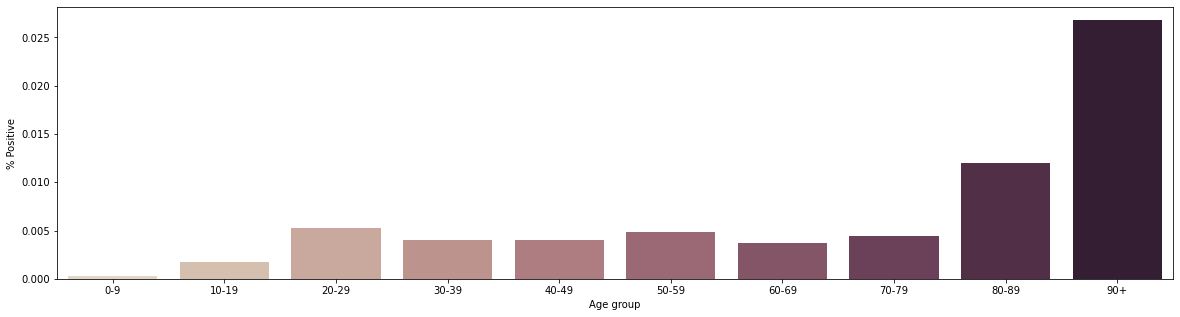

In [183]:
plt.figure(figsize=(20,5))
sns.barplot(x="Age group", y="% Positive", data=agegroup_df, palette="ch:.25")

In the plot above it's visible that the oldest age groups (80-89 & 90+) have the most COVID-19 infections if we look at percentages. The percentages in all age groups are not higher than 0.027 percent.

## Province

We will do the same thing, but for 'Province' instead of 'Age'. 

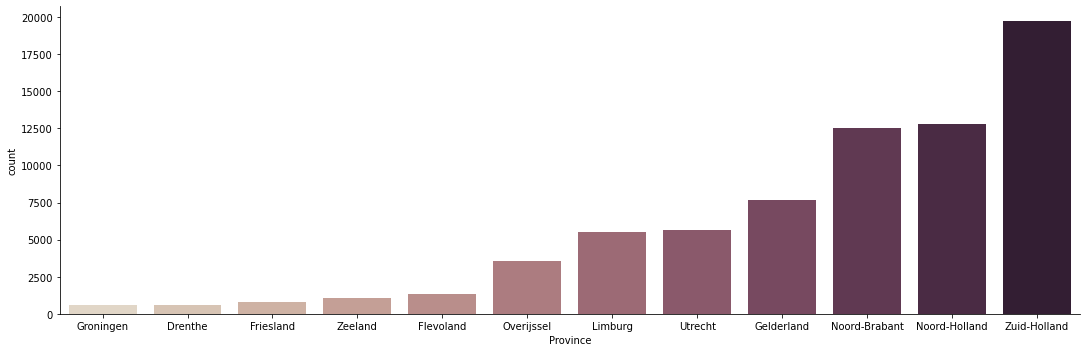

In [235]:
order = covid_df['Province'].value_counts(ascending = True).index
sns.catplot(x="Province", kind="count", palette="ch:.25", data=covid_df, height=5, aspect=3, order=order)

This graph shows the distribution of positive cases per province. It is clear that South-Holland has the most COVID-19 positive tested inhabitants. This makes sense, if you think about the extra measures that were active in Rotterdam for instance (wearing masks in the city center). We will calculate percentages by using data from StatLine once more. https://opendata.cbs.nl/statline/#/CBS/nl/dataset/70072NED/table?fromstatweb This data has been updated last on the 17th of June, so it doesn't account for changes after that.

In [216]:
province_df = pd.read_csv('Regionale_kerncijfers_Nederland.csv', sep=';')

In [217]:
province_df.columns = ['Perioden', 'Regio', 'Aantal']

In [218]:
province_df = province_df.sort_values('Regio')
province_df

,Perioden,Regio,Aantal
2,2020,Drenthe (PV),493682
4,2020,Flevoland (PV),423021
1,2020,Fryslân (PV),649957
5,2020,Gelderland (PV),2085952
0,2020,Groningen (PV),585866
11,2020,Limburg (PV),1117201
10,2020,Noord-Brabant (PV),2562955
7,2020,Noord-Holland (PV),2879527
3,2020,Overijssel (PV),1162406
6,2020,Utrecht (PV),1354834


In [219]:
province_df['Positive'] = list(covid_df['Province'].value_counts().sort_index())
province_df

,Perioden,Regio,Aantal,Positive
2,2020,Drenthe (PV),493682,612
4,2020,Flevoland (PV),423021,1348
1,2020,Fryslân (PV),649957,829
5,2020,Gelderland (PV),2085952,7671
0,2020,Groningen (PV),585866,608
11,2020,Limburg (PV),1117201,5492
10,2020,Noord-Brabant (PV),2562955,12534
7,2020,Noord-Holland (PV),2879527,12817
3,2020,Overijssel (PV),1162406,3537
6,2020,Utrecht (PV),1354834,5620


In [220]:
province_df['% Positive'] = 0
for i in range(len(province_df)):
    province_df.iloc[i,1] = province_df.iloc[i,1][:-4]
    province_df.iloc[i,4] = province_df.iloc[i,3]/province_df.iloc[i,2]
province_df

,Perioden,Regio,Aantal,Positive,% Positive
2,2020,Drenthe,493682,612,0.001240
4,2020,Flevoland,423021,1348,0.003187
1,2020,Fryslân,649957,829,0.001275
5,2020,Gelderland,2085952,7671,0.003677
0,2020,Groningen,585866,608,0.001038
11,2020,Limburg,1117201,5492,0.004916
10,2020,Noord-Brabant,2562955,12534,0.004890
7,2020,Noord-Holland,2879527,12817,0.004451
3,2020,Overijssel,1162406,3537,0.003043
6,2020,Utrecht,1354834,5620,0.004148


<AxesSubplot:xlabel='Regio', ylabel='% Positive'>

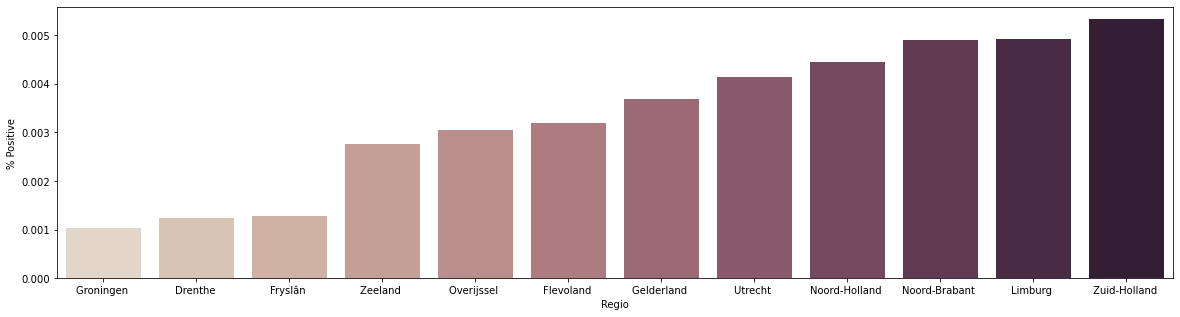

In [575]:
order = province_df.sort_values("% Positive").Regio
plt.figure(figsize=(20,5))
sns.barplot(x="Regio", y="% Positive", data=province_df, palette="ch:.25", order = order)

If we look at the percentages of people tested positive for COVID-19, we see that the difference per province is smaller than it seemed in the first graph. However, South-Holland still has the most COVID-19 cases in percentages. The three provinces with the lowest percentage are Groningen, Drenthe and Friesland. These provinces are all in the northern of the Netherlands. 

## Time series

Now we want to see the amount of infected people in the Netherlands over time. This will require using the 'Date_statistics' column, which indicates when the person was tested positive. We first transform the column type from object to datetime.

In [126]:
covid_df.dtypes

Date_file                    object
Date_statistics              object
Date_statistics_type         object
Agegroup                     object
Sex                          object
Province                     object
Hospital_admission           object
Deceased                     object
Week_of_death               float64
Municipal_health_service     object
dtype: object

In [129]:
covid_df['Date_statistics'] = pd.to_datetime(covid_df['Date_statistics'])
covid_df.dtypes

Date_file                           object
Date_statistics             datetime64[ns]
Date_statistics_type                object
Agegroup                            object
Sex                                 object
Province                            object
Hospital_admission                  object
Deceased                            object
Week_of_death                      float64
Municipal_health_service            object
dtype: object

In [141]:
covid_df['Count'] = 1

We want to display the data per week to discover trends. To do so, we will use the Date_statistics column as an index. This will allow us to use the resample method, where we resample on week. This means that for each week, the sum will be taken of our 'Count' column, which we created in the cell above. This will result in a total of positive cases per week for the Netherlands in total.

In [264]:
covid_df.index = covid_df.Date_statistics
# covid_df = covid_df.drop("Date_statistics", axis = 1)
# covid_df = covid_df.reset_index()

Text(0, 0.5, '# Positive cases')

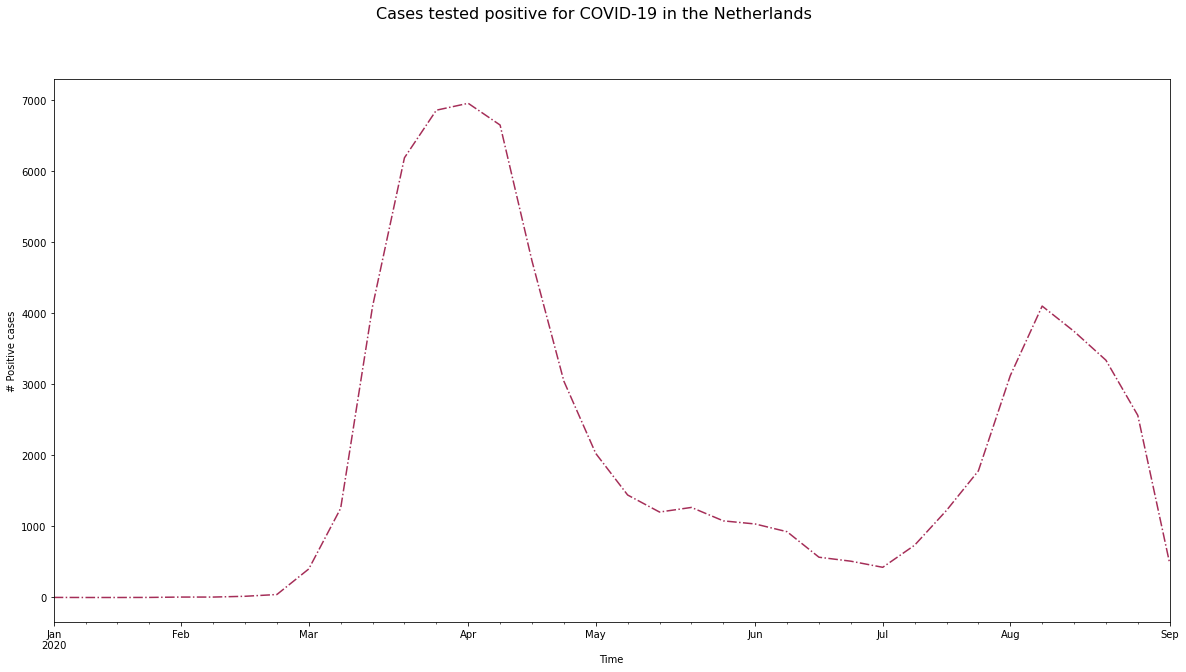

In [573]:
fig, ax = plt.subplots()
fig.suptitle('Cases tested positive for COVID-19 in the Netherlands', fontsize=16)
covid_df.resample('W').Count.sum().plot(style='-.', color = '#a52e58', figsize=(20,10))
plt.xlabel('Time')
plt.ylabel('# Positive cases')

When we look at the total positive COVID-19 cases, we see two big peaks overtime. The biggest peak started in March and was at its top in the beginning of April. It started decreasing very steeply until May. In July, we see a new peak starting to arise. This was at its top during the beginning of August, but decreased in the second week. This peak is smaller than the first one.

We now want to look at this time series per province. To make sure that we can create lines per province, we create a new dataframe and use the method get_dummies to ensure that we have separate columns for each province. Each row has one province, so a value of 1 will be filled out in the corresponding province column. We will resample again in weeks and take the sum. For 2020-01-01, all cases that were tested positive for that day will be visible per province.

In [833]:
covid_df.index = covid_df.Date_statistics
province_date_df = pd.get_dummies(covid_df.Province)
province_date_df = province_date_df.resample('W').sum()
province_date_df

,Drenthe,Flevoland,Friesland,Gelderland,Groningen,Limburg,Noord-Brabant,Noord-Holland,Overijssel,Utrecht,Zeeland,Zuid-Holland
Date_statistics,,,,,,,,,,,,
2020-01-05,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
2020-01-12,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2020-01-19,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2020-01-26,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2020-02-02,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000,2.00000,0.00000,0.00000,1.00000
2020-02-09,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,0.00000,1.00000,0.00000,0.00000,0.00000
2020-02-16,1.00000,1.00000,1.00000,2.00000,0.00000,1.00000,3.00000,5.00000,2.00000,0.00000,0.00000,1.00000
2020-02-23,0.00000,1.00000,0.00000,4.00000,0.00000,6.00000,13.00000,9.00000,0.00000,5.00000,0.00000,4.00000
2020-03-01,10.00000,5.00000,3.00000,36.00000,4.00000,34.00000,145.00000,32.00000,16.00000,59.00000,3.00000,55.00000


Text(0, 0.5, '# Positive cases')

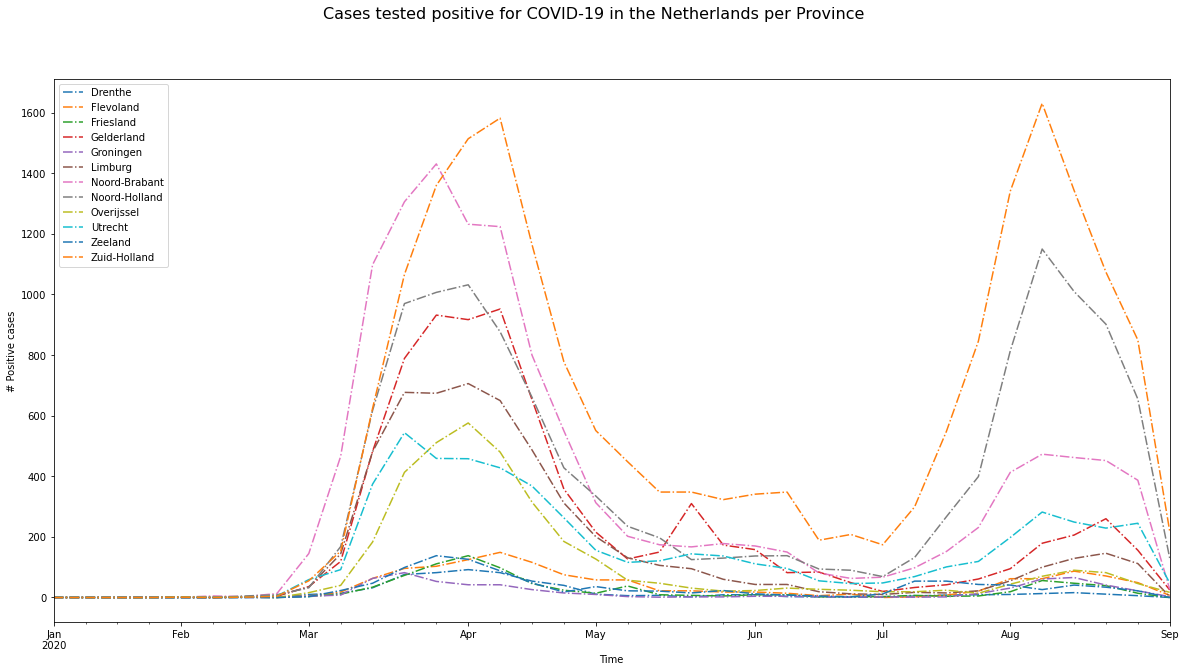

In [834]:
fig, ax = plt.subplots()
fig.suptitle('Cases tested positive for COVID-19 in the Netherlands per Province', fontsize=16)
province_date_df.plot(figsize=(20,10), style='-.', ax = ax)
plt.xlabel('Time')
plt.ylabel('# Positive cases')

When we take a look at the data per week for each province, we see some interesting things. First of all, South-Holland has had two major peaks. The second peak has a higher top than the first one, which is remarkable. North-Holland also seems to have a bigger second peak.  Seeing this made me have more empathy for the extra COVID-19 measures in Rotterdam and Amsterdam, even though we cannot see the cases on a municipality level. These measures are not active anymore though. What is also standing out is the fact that North-Brabant had very large first peak, almost as large as South-Holland. Their second peak is way lower if we compare it to South-Holland. The same trend is visible for Gelderland, Limburg and Overijssel. 

We will now look at the time series per age group, which follows the same steps as for provinces.

Text(0, 0.5, '# Positive cases')

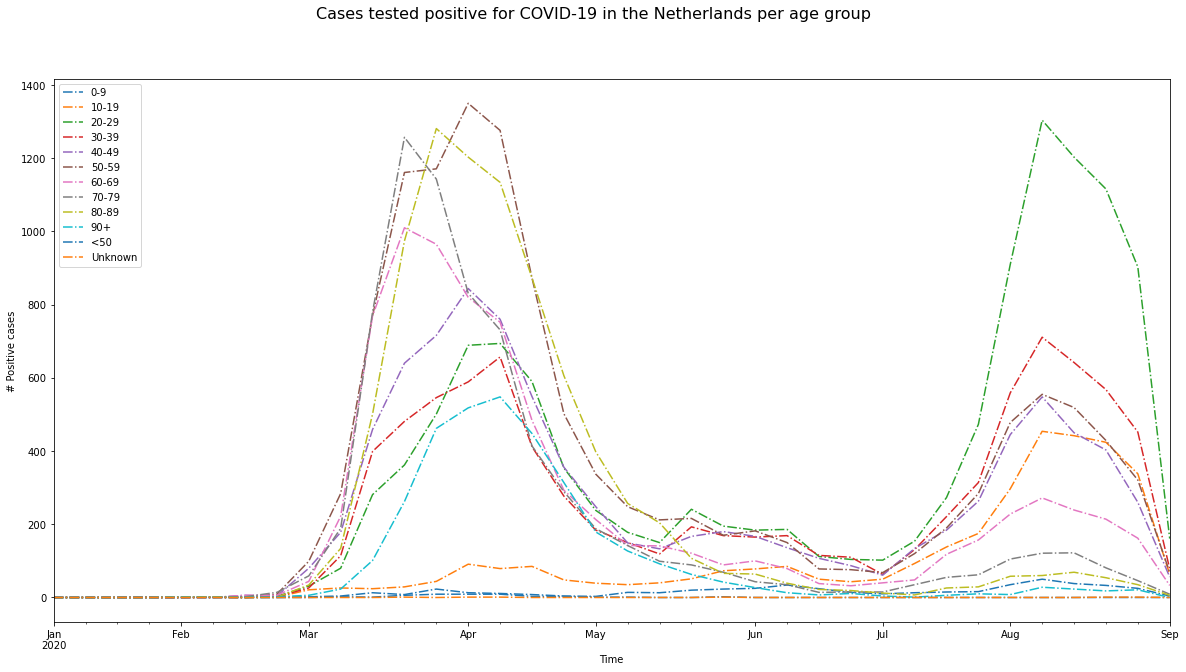

In [568]:
fig, ax = plt.subplots()
fig.suptitle('Cases tested positive for COVID-19 in the Netherlands per age group', fontsize=16)
covid_df.index = covid_df.Date_statistics
age_date_df = pd.get_dummies(covid_df.Agegroup)
age_date_df.resample('W').sum().plot(figsize=(20,10), style='-.', ax = ax)
plt.xlabel('Time')
plt.ylabel('# Positive cases')

This graph shows the distribution of postive cases between age groups over time. This clearly shows that adults from 20-29 years are tested positive more in the second peak. It seems that positive cases in elder groups (50+) decreased in the second peak compared to the first peak. The only group that has similar peaks is are the people of age 30-39. 

Next, we want to look at all the cases where the person died of COVID-19. What is the average time between being tested positive and passing. To look at this, we need to transform the 'death_week' column. This column contains a string based on  YYYYMM according to the ISO-week notation (example: week 15 is '202015'). We will transform it to a timestamp of the date of the monday of the week. This will make sure that we can visualize our data per month easier.

In [843]:
from isoweek import Week
import math
covid_df['death_week'] = None
for i in range(len(covid_df)):
    if pd.isnull(covid_df.iloc[i, 8]) == False:
        week_number = int(float(str(covid_df.iloc[i, 8])[4:]))
        covid_df.iloc[i, 11] = Week(2020, week_number).monday()

Text(0, 0.5, '# Cases')

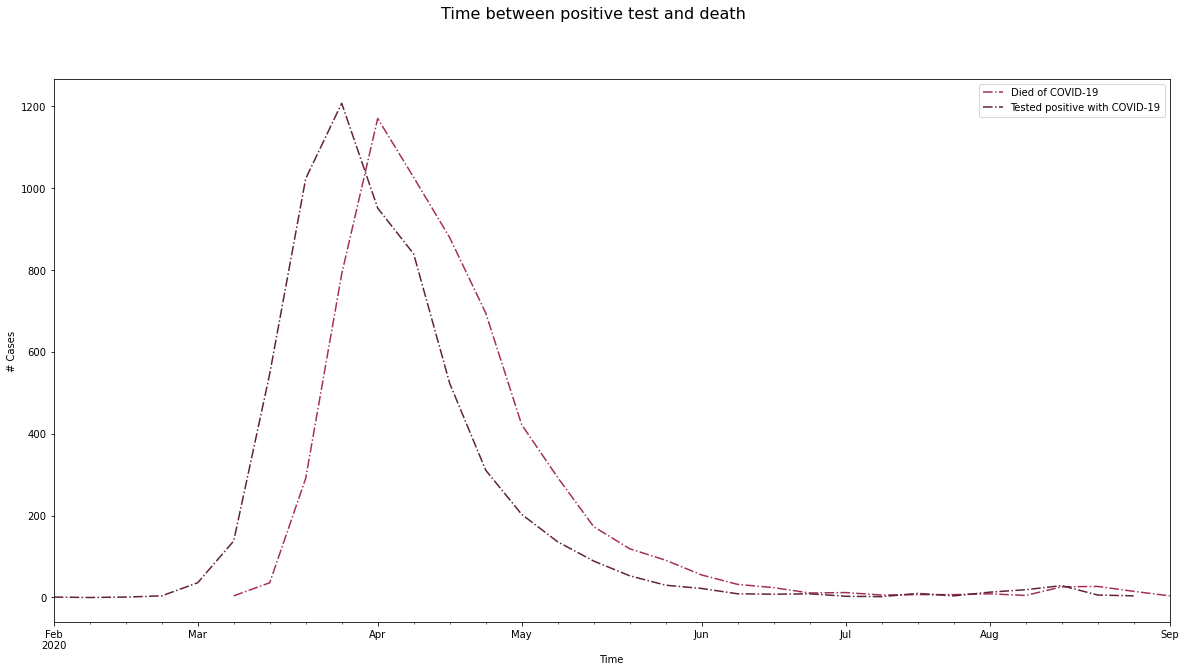

In [902]:
covid_df['death_week'] = pd.to_datetime(covid_df['death_week'])
death_df = covid_df[covid_df['death_week'] > '2020-01-01 00:00:00']
death_df.index = death_df['death_week']
fig, ax = plt.subplots()
fig.suptitle('Time between positive test and death', fontsize=16)
death_df.resample('W').Count.sum().plot(style='-.', color = '#a52e58',figsize=(20,10), ax=ax, label='Died of COVID-19')
death_df.index = death_df['Date_statistics']
death_df.resample('W').Count.sum().plot(style='-.', color = '#602040',figsize=(20,10), ax=ax, label='Tested positive with COVID-19')
ax.legend()
plt.xlabel('Time')
plt.ylabel('# Cases')

In [903]:
death_df['days_before_death'] = death_df.death_week - death_df.Date_statistics
for i in range(len(death_df)):
    death_df.iloc[i, 12] = death_df['days_before_death'][i].days
for i in range(len(death_df)):
    if death_df.iloc[i,12] < 0:
        death_df.iloc[i,12] = 0

c:\users\gebruiker\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\gebruiker\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [904]:
death_df.days_before_death.mean()

9.343875421415957

In [905]:
death_df = death_df.drop('Date_statistics', axis = 1)

In [906]:
death_df.reset_index()
death_df.value_counts("death_week").sort_index()

death_week
2020-03-02       4
2020-03-09      36
2020-03-16     291
2020-03-23     790
2020-03-30    1170
2020-04-06    1026
2020-04-13     879
2020-04-20     695
2020-04-27     422
2020-05-04     293
2020-05-11     173
2020-05-18     119
2020-05-25      91
2020-06-01      55
2020-06-08      32
2020-06-15      24
2020-06-22      11
2020-06-29      12
2020-07-06       6
2020-07-13       7
2020-07-20       7
2020-07-27       9
2020-08-03       5
2020-08-10      26
2020-08-17      27
2020-08-24      15
2020-08-31       4
dtype: int64

## Global

In [596]:
global_df = pd.read_csv('full_data.csv')
population_df = pd.read_csv('locations.csv')

In [597]:
total_df = global_df[global_df['location'] == 'World'].groupby('date', as_index=False).agg({"new_cases": "sum"})

In [598]:
global_df['date'] = pd.to_datetime(global_df['date'])
global_df.index = global_df['date']
total_df['date'] = pd.to_datetime(total_df['date'])
total_df.index = total_df['date']

In [599]:
global_df[global_df['location'] == 'Netherlands']

,date,location,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths
date,,,,,,,,,,
2019-12-31,2019-12-31,Netherlands,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2020-01-01,2020-01-01,Netherlands,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2020-01-02,2020-01-02,Netherlands,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2020-01-03,2020-01-03,Netherlands,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2020-01-04,2020-01-04,Netherlands,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-09-03,2020-09-03,Netherlands,914.0,5.0,71971.0,6226.0,3925.0,20.0,7508.0,54.0
2020-09-04,2020-09-04,Netherlands,421.0,0.0,72392.0,6226.0,3836.0,17.0,7400.0,44.0
2020-09-05,2020-09-05,Netherlands,744.0,2.0,73136.0,6228.0,4073.0,17.0,7610.0,42.0


Text(0, 0.5, '# Positive cases')

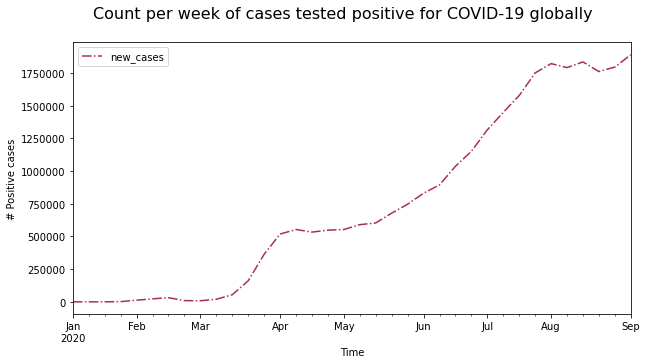

In [600]:
fig, ax = plt.subplots()
ax = plt.gca()
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
fig.suptitle('Count per week of cases tested positive for COVID-19 globally', fontsize=16)
total_df[total_df['date'] != '2020-09-07'].resample('W').new_cases.sum().plot(style='-.', color = '#a52e58',figsize=(10,5), ax = ax)
ax.legend()
plt.xlabel('Time')
plt.ylabel('# Positive cases')

When we take a look at the global numbers, we see that the amount of positive tested people was at an all time high in the beginning of September. This graph is aggregated per week (MON-SUN), I removed the entries from 2020-09-07 as this is a new week and skewes the graph. https://ourworldindata.org/coronavirus-source-data

In [601]:
#Check whether there are duplicates in the population dataset
len(set(population_df.iloc[:,0])) == len(population_df)

True

In [602]:
population_total = population_df.iloc[:,4].sum()

In [603]:
total_df['new_cases_percentage'] = total_df['new_cases']/population_total

In [604]:
dutch_population_total = population_df[population_df['location'] == 'Netherlands'].iloc[0,4]

In [605]:
nl_df = global_df[global_df['location'] == 'Netherlands']

In [606]:
nl_df['new_cases_percentage'] = nl_df['new_cases'] / dutch_population_total

c:\users\gebruiker\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


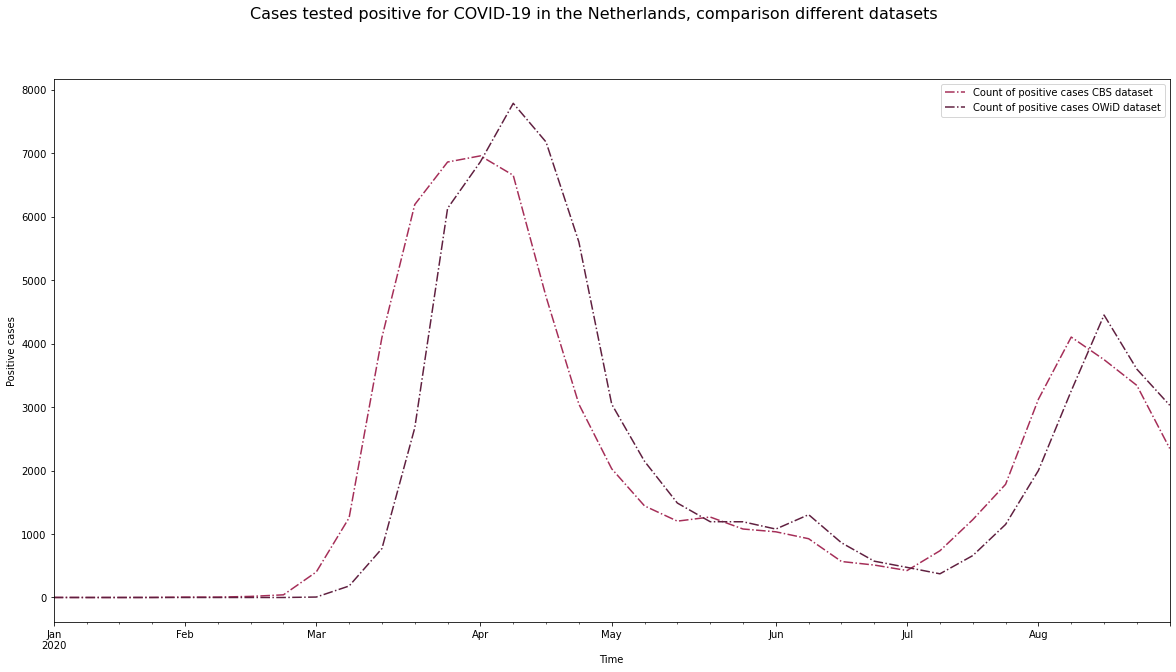

In [607]:
fig, ax = plt.subplots()
ax = plt.gca()
fig.suptitle('Cases tested positive for COVID-19 in the Netherlands, comparison different datasets', fontsize=16)
covid_df[covid_df['Date_statistics'] < '2020-08-30'].resample('W').Count.sum().plot(style='-.', color = '#a52e58', ax = ax, label = 'Count of positive cases CBS dataset')
nl_df[nl_df['date'] < '2020-08-30'].resample('W').new_cases.sum().plot(style='-.', color = '#602040',figsize=(20,10), ax = ax, label = 'Count of positive cases OWiD dataset')
plt.xlabel('Time')
plt.ylabel('Positive cases')
ax.legend()

This graph displays the data of positive cases in the Netherlands again. The lighter line represents the data from the CBS (also visible in a previous graph) and the dark line shows the data from Our World in Data (reports based on data from the European Center for Disease Prevention and Control). The data differs quite a bit, even though the overall trend seems to be the same. The data from the OWiD dataset seems to be a bit behind on the dates that a person was tested positive. I assume that the data from CBS is more accurate regarding the Dutch situation. The European Center for Disease Prevention and Control reports on the COVID-19 situation all over the world, while the CBS dataset is focused solely on the Netherlands. This does show that multiple reliable sources can have contradictory data. 

In [608]:
nl_df_cbs = pd.DataFrame(covid_df.resample('W').Count.sum())
nl_df_cbs['new_cases_percentage'] = nl_df_cbs['Count']/dutch_population_total

In [609]:
nl_df_cbs = nl_df_cbs.reset_index()
nl_df_cbs = nl_df_cbs[nl_df_cbs['Date_statistics'] < '2020-09-01']
nl_df_cbs.index = nl_df_cbs['Date_statistics']

Text(0, 0.5, '# Positive cases')

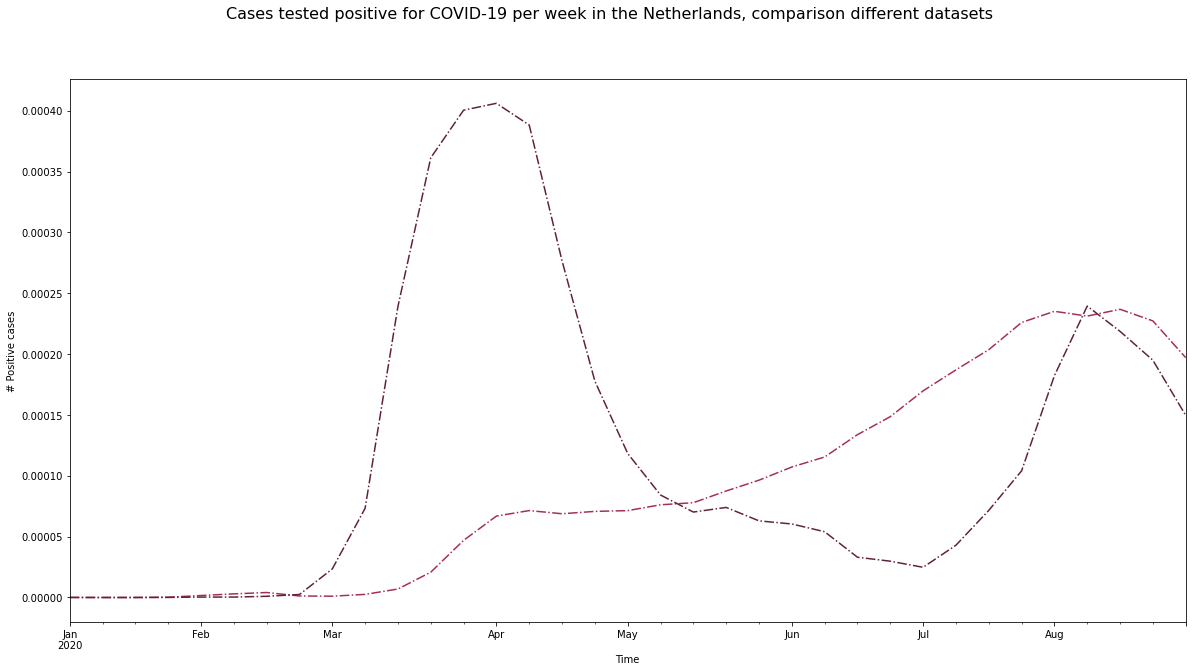

In [610]:
fig, ax = plt.subplots()
ax = plt.gca()
fig.suptitle('Cases tested positive for COVID-19 per week in the Netherlands, comparison different datasets', fontsize=16)
total_df[total_df['date'] < '2020-08-30'].resample('W').new_cases_percentage.sum().plot(style='-.', color = '#a52e58', ax = ax)
nl_df_cbs.new_cases_percentage.plot(style='-.', color = '#602040',figsize=(20,10), ax = ax)
plt.xlabel('Time')
plt.ylabel('# Positive cases')

If we look at the positive cases globally and in the Netherlands, we see very different trends. We had a very large first peak, drastically higher than the global average. It seems that we learned from that and in the beginning of May we came to a point where our percentage of positive cases per week was lower than the global average. This percentage kept decreasing until the beginning of July, while the global average kept rising. After that, the percentage increased in the Netherlands as well, in the beginning of August there was a small moment where we rose above the average percentage, but we seemed able to correct this again and decrease below the average in the following weeks.

In [700]:
top20_df = global_df.groupby('location', as_index=False).agg({"new_cases": "sum"})

In [701]:
top20_df = top20_df[top20_df['location'] != 'World']

In [702]:
top20_df = pd.merge(top20_df, population_df, on="location")

In [703]:
top20_df['percentage'] = top20_df['new_cases'] / top20_df['population']

In [704]:
top20_df = top20_df.drop([91])

In [706]:
#top20_df = top20_df.drop(['countriesAndTerritories', 'population_year'], axis=1)
top20_df['new_cases'] = top20_df['new_cases'].astype(int)
top20_df['population'] = top20_df['population'].astype(int)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
top20_df = top20_df.sort_values('percentage', ascending = False).iloc[:20,:]
top20_df = top20_df.reset_index().iloc[:,1:]
top20_df

,location,new_cases,countriesAndTerritories,continent,population_year,population,percentage
0,Qatar,120095,Qatar,Asia,2020.000,2881060,0.042
1,Bahrain,54771,Bahrain,Asia,2020.000,1701583,0.032
2,Aruba,2449,Aruba,North America,2020.000,106766,0.023
3,Panama,97043,Panama,North America,2020.000,4314768,0.022
4,Chile,422510,Chile,South America,2020.000,19116209,0.022
5,San Marino,735,San_Marino,Europe,2020.000,33938,0.022
6,Kuwait,89582,Kuwait,Asia,2020.000,4270563,0.021
7,Peru,689977,Peru,South America,2020.000,32971846,0.021
8,Brazil,4137521,Brazil,South America,2020.000,212559409,0.019
9,United States,6276421,United_States_of_America,North America,2020.000,331002647,0.019


This table displays the top 20 countries with the highest average COVID-19 positive percentage. We can see a mix of small and large countries and a mix of continents.

In [734]:
global_df = pd.merge(global_df, population_df, on="location")

In [766]:
continent_df = global_df.groupby(['continent', 'date']).agg({'new_cases':'sum'})
continent_df = pd.DataFrame(continent_df).reset_index()

<AxesSubplot:xlabel='Time', ylabel='# Positive cases'>

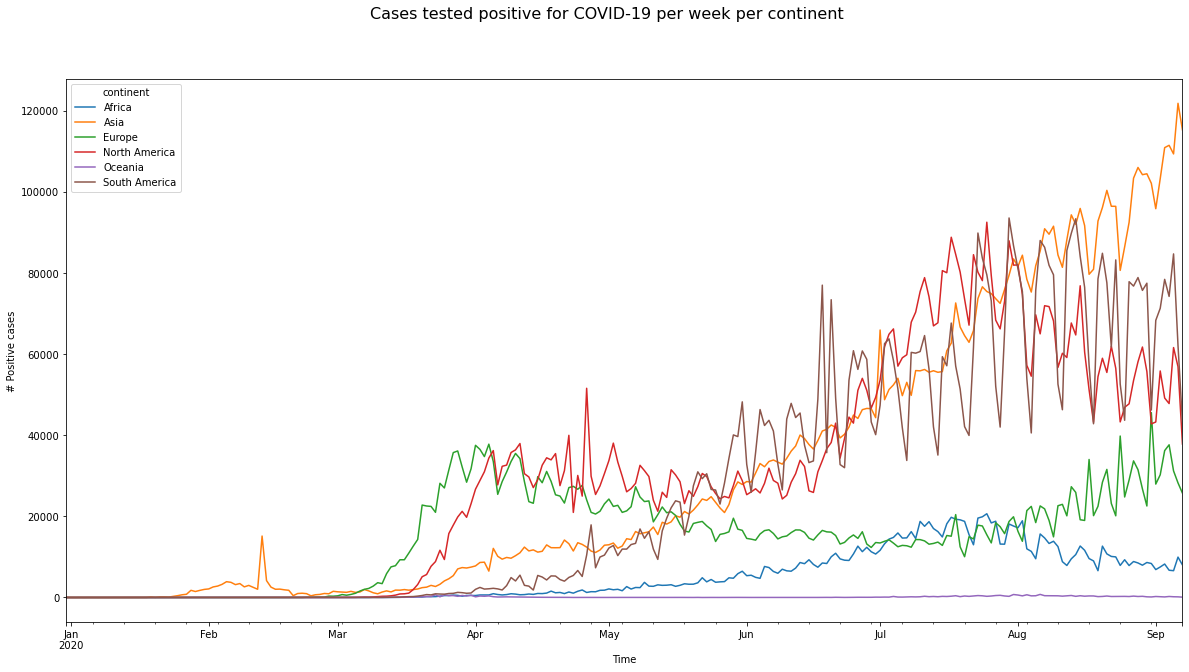

In [800]:
fig, ax = plt.subplots()
ax = plt.gca()
fig.suptitle('Cases tested positive for COVID-19 per week per continent', fontsize=16)
continent_df.pivot_table(index='date', columns='continent', values='new_cases').plot(style='-',figsize=(20,10), ax = ax, xlabel = 'Time', ylabel = '# Positive cases')

In [768]:
continent_population_df = population_df.groupby(['continent']).agg({'population':'sum'})
continent_population_df.columns = ['population']
continent_population_df = continent_population_df.reset_index()
continent_population_df

,continent,population
0,Africa,1339423921.00000
1,Asia,4599891093.00000
2,Europe,748506210.00000
3,North America,591242473.00000
4,Oceania,40958320.00000
5,South America,430461090.00000


In [769]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
continent_df = pd.merge(continent_df, continent_population_df, on="continent")

In [781]:
continent_df['percentage'] = continent_df['new_cases']/continent_df['population']
continent_percentage_df = continent_df.groupby(['continent']).agg({'new_cases':'sum', 'population':'first'})
continent_percentage_df['percentage'] = continent_percentage_df['new_cases'] / continent_percentage_df['population']
continent_percentage_df = continent_percentage_df.reset_index()
continent_percentage_df

,continent,new_cases,population,percentage
0,Africa,1300143.00000,1339423921.00000,0.00097
1,Asia,7794306.00000,4599891093.00000,0.00169
2,Europe,3793616.00000,748506210.00000,0.00507
3,North America,7520990.00000,591242473.00000,0.01272
4,Oceania,30629.00000,40958320.00000,0.00075
5,South America,6710417.00000,430461090.00000,0.01559


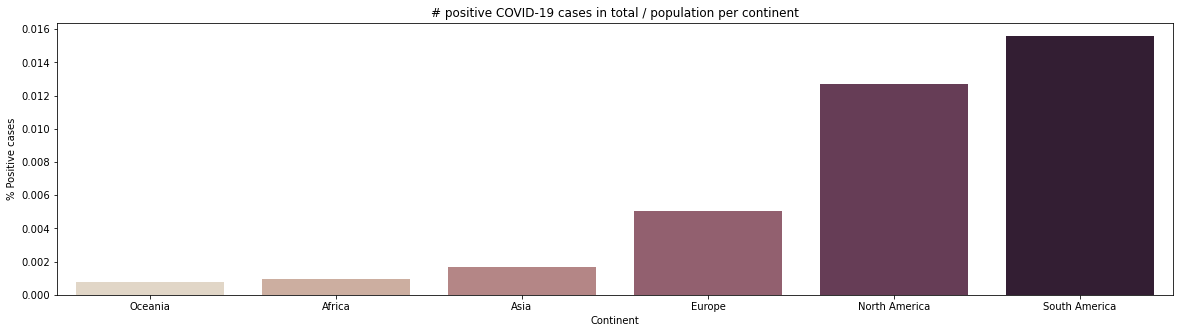

In [823]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x="continent", y = "percentage", palette="ch:.25", data=continent_percentage_df, order = continent_percentage_df.sort_values('percentage').continent)
ax.set(xlabel='Continent', ylabel='% Positive cases')
ax.set_title('# positive COVID-19 cases in total / population per continent')
plt.show()

This graph shows the total amount of COVID-19 positive tested cases / the population per continent to check how many percent of the population is or has been infected. This illustrates that North America and South America have more infections in percentages. Europe is in the middle, and Oceania, Africa and Asia have a relatively low percentage of infected inhabitants. 

<AxesSubplot:xlabel='Time', ylabel='% Positive cases'>

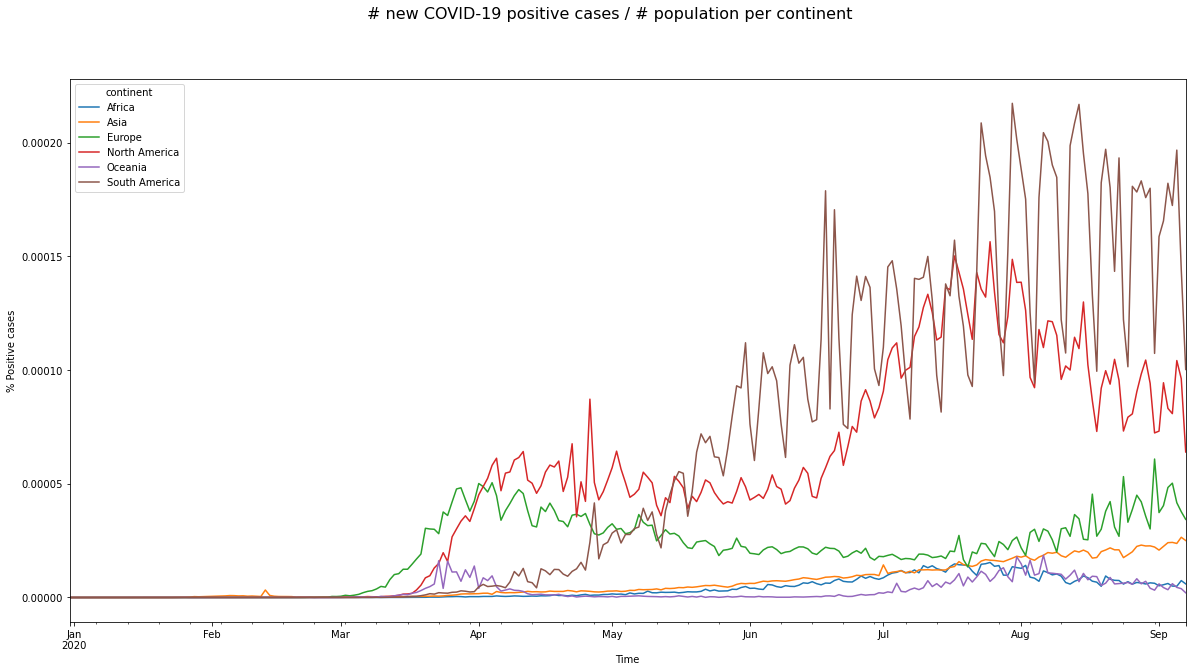

In [809]:
fig, ax = plt.subplots()
ax = plt.gca()
fig.suptitle('# new COVID-19 positive cases / # population per continent', fontsize=16)
continent_df.pivot_table(index='date', columns='continent', values='percentage').plot(style='-',figsize=(20,10),  ax = ax, xlabel = 'Time', ylabel = '% Positive cases')

The graph above illustrates the positive cases per continent over time. We have divided the cases per day per population for each continent, so we can see the relative situation over time. This again shows that there are relatively more infections in North America and South America. It is interesting to see that Europe had a higher percentage infections in the beginning of the crisis, but North America got relatively more cases every day since the beginning of April. South America began getting more infections in the first weeks of May and it kept rising from there. The percentage of infections in Europe has been rising since the beginning of August again. 